# データ分析とモデル作成sample

## 内容

- タイタニックのデータを使用して，データ分析とモデル作成を行う

### 各カラムの意味

1. **survived**: 乗客が生存したかどうか（0 = 死亡, 1 = 生存）。
2. **pclass**: 乗客のチケットクラス（1 = 1等, 2 = 2等, 3 = 3等）。
3. **sex**: 乗客の性別（male = 男性, female = 女性）。
4. **age**: 乗客の年齢。NaNの値も含まれ、年齢が不明な場合があります。
5. **sibsp**: 兄弟姉妹または配偶者の数。乗船した兄弟姉妹または配偶者の数を示します。
6. **parch**: 両親または子供の数。乗船した親または子供の数を示します。
7. **fare**: 乗船料金。乗客が支払った運賃を表します。
8. **embarked**: 乗船港（C = Cherbourg, Q = Queenstown, S = Southampton）。
9. **class**: チケットのクラスを文字列で示したもの（'First', 'Second', 'Third'）。
10. **who**: 乗客のカテゴリー（'man', 'woman', 'child'）。
11. **adult_male**: 乗客が成人男性かどうか（True = 成人男性, False = それ以外）。
12. **deck**: 乗客が乗っていたデッキ（甲板）のレベル。NaNの値も多く含まれます。
13. **embark_town**: 乗船した港の町（'Cherbourg', 'Queenstown', 'Southampton'）。
14. **alive**: 生存か死亡かを文字列で示したもの（'yes' = 生存, 'no' = 死亡）。
15. **alone**: 乗客が単独で乗船したかどうか（True = 単独, False = 家族や他の人と一緒）。

# Load modules
- moduleのloadを行う.

In [1]:
!pip install japanize_matplotlib
!pip install optuna optuna_integration
!pip install shap

In [2]:
# ライブラリ読み込み
import sys, os
import time
import gc
from datetime import datetime as dt
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import japanize_matplotlib

import joblib
import re # 正規表現

import seaborn as sns

from sklearn.model_selection import train_test_split
# from sklearn.model_selection import GridSearchCV

# 評価関数
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

In [3]:
# LightGBM
import lightgbm as lgb

# optunaによるLightGBM
import optuna.integration.lightgbm as optuna_lgb

# SHAP
import shap

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
gc.collect()

0

# Configure

## Google Colab用設定

In [5]:
# 各自書き換えてください
current_project_dpath = '/content/drive/MyDrive/work/matsue_ct/20240831_データ分析研修'
print(current_project_dpath)

/content/drive/MyDrive/work/matsue_ct/20240831_データ分析研修


In [6]:
from google.colab import drive

drive.mount('/content/drive')
os.chdir(current_project_dpath)

# 現在のディレクトリを確認
print(os.getcwd())

Mounted at /content/drive
/content/drive/MyDrive/work/matsue_ct/20240831_データ分析研修


## pandas.DataFrameの表示行数・列数を変更

In [7]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

## warningの表示を削除

In [8]:
# warningの削除
import warnings
warnings.filterwarnings('ignore')

## random seed
- random系moduleのseed値を設定する.

In [9]:
# random系moduleのseed値を設定
random.seed(57)
np.random.seed(57)

# Constants

## date

In [10]:
today_dt = dt.today()
today_str = dt.strftime(today_dt, '%Y%m%d')
today_str

'20240830'

## paths

In [11]:
input_dpath = './input/'
output_dpath = './output/'

# Functions

In [12]:
def logistic(x):
    """
    logistic関数を計算します。

    logistic関数は、ロジスティック回帰などで使用されるシグモイド関数であり、
    入力の実数値を0から1の範囲の値にマッピングします。

    パラメータ
    ----------
    x : float または np.ndarray
        入力値。実数または実数の配列。

    戻り値
    -------
    float または np.ndarray
        入力xに対するlogistic関数の値。
    """
    return 1 / (1 + np.exp(-x))

In [13]:
def logit(p):
    """
    logit関数を計算します。

    logit関数は、ロジスティック関数（シグモイド関数）の逆関数であり、確率をオッズ比に変換します。
    確率pは0から1の範囲内である必要があります。

    パラメータ
    ----------
    p : float または np.ndarray
        確率値（0から1の範囲内）。

    戻り値
    -------
    float または np.ndarray
        入力pに対するlogit値。
    """
    # 安全性チェック：0と1の値が入力されると、logが無限大になるため小さな値を追加
    p = np.clip(p, 1e-15, 1 - 1e-15)

    return np.log(p / (1 - p))


# Load data

## 前処理済み中間データ

In [14]:
# 前処理済み中間データのdictを読み取る
pp_data_dict = joblib.load(f'{input_dpath}pp_titanic_data_dict.pkl3')

In [15]:
type(pp_data_dict)

dict

### dictからデータを読み取る

In [16]:
train_x = pp_data_dict['train_x']
train_y = pp_data_dict['train_y']
test_x = pp_data_dict['test_x']
test_y = pp_data_dict['test_y']

In [17]:
# shapeの確認
train_x.shape, train_y.shape, test_x.shape, test_x.shape

((499, 54), (499,), (215, 54), (215, 54))

# LightGBM

## set vars

In [18]:
# 説明変数
features = train_x.columns.tolist()

# 目的変数
target = 'survived'

In [19]:
len(features)

54

In [20]:
features[:5]

['age', 'fare', 'adult_male_False', 'adult_male_True', 'adult_male_nan']

In [21]:
features

['age',
 'fare',
 'adult_male_False',
 'adult_male_True',
 'adult_male_nan',
 'embark_town_Cherbourg',
 'embark_town_Queenstown',
 'embark_town_Southampton',
 'embark_town_nan',
 'who_child',
 'who_man',
 'who_woman',
 'who_nan',
 'pclass_1.0',
 'pclass_2.0',
 'pclass_3.0',
 'pclass_nan',
 'class_First',
 'class_Second',
 'class_Third',
 'class_nan',
 'sex_female',
 'sex_male',
 'sex_nan',
 'parch_0.0',
 'parch_1.0',
 'parch_2.0',
 'parch_3.0',
 'parch_4.0',
 'parch_5.0',
 'parch_6.0',
 'parch_nan',
 'alone_False',
 'alone_True',
 'alone_nan',
 'sibsp_0.0',
 'sibsp_1.0',
 'sibsp_2.0',
 'sibsp_3.0',
 'sibsp_4.0',
 'sibsp_5.0',
 'sibsp_nan',
 'deck_A',
 'deck_B',
 'deck_C',
 'deck_D',
 'deck_E',
 'deck_F',
 'deck_G',
 'deck_nan',
 'embarked_C',
 'embarked_Q',
 'embarked_S',
 'embarked_nan']

## 一部前処理

### ハイパーパラメータ用にデータを分ける

In [22]:
# 7:3の割合でホールドアウト法を行う.
train_train_x, train_valid_x, train_train_y, train_valid_y = train_test_split(
    train_x, train_y,
    test_size=0.3,
    random_state=57,
    shuffle=True
)

In [23]:
train_train_x.shape, train_train_y.shape, train_valid_x.shape, train_valid_y.shape

((349, 54), (349,), (150, 54), (150,))

### LightGBM向けにデータセットを作成する

In [24]:
# LightGBM用データセットを生成する
lgb_train_train_dataset = lgb.Dataset(
    train_train_x,
    train_train_y
)
lgb_train_valid_dataset = lgb.Dataset(
    train_valid_x,
    train_valid_y,
    reference=lgb_train_train_dataset
)

In [25]:
# LightGBM用データセットを生成する
lgb_train_dataset = lgb.Dataset(
    train_x,
    train_y
)

## Optunaによるハイパーパラメータチューニング

In [26]:
# ハイパーパラメータ
lgbc_params = {
    # 問題設定: 2値分類
    'objective': 'binary',

    # 評価関数: AUC
    'metric': 'auc',
    'verbosity': -1,
}

In [27]:
# モデルの学習を行う.
optuna_lgbc = optuna_lgb.train(
    lgbc_params, # ハイパーパラメータ
    train_set=lgb_train_train_dataset, # 学習データ
    num_boost_round=100, # boostingを行う回数
    valid_sets=lgb_train_valid_dataset, # 検証データ
    verbosity=20 # boosting20回に1回結果出力
)

[I 2024-08-30 23:08:38,837] A new study created in memory with name: no-name-dfbef6a3-6c64-4877-9a4d-8200ab1b969a
min_child_samples, val_score: 0.890979: 100%|##########| 5/5 [00:00<00:00, 19.75it/s]


In [28]:
# 最適なパラメータの確認
best_lgbc_params = optuna_lgbc.params
best_lgbc_params

{'objective': 'binary',
 'metric': 'auc',
 'verbosity': -1,
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 31,
 'feature_fraction': 0.62,
 'bagging_fraction': 0.42007176224001774,
 'bagging_freq': 6,
 'min_child_samples': 20,
 'num_iterations': 100}

## create model

In [29]:
# モデルの学習を行う.
lgbc = lgb.train(
    best_lgbc_params, # 最適なハイパーパラメータ
    train_set=lgb_train_dataset, # 学習データ
    num_boost_round=100 # boostingを行う回数
)

## 精度評価

### train

In [30]:
# train予測
# lgbm本家ではpredictが確率になっている
lgbc_prob_train_y = lgbc.predict(train_x)

# 確率が0.5以上の時1と判定する.
lgbc_pred_train_y = np.where(
    lgbc_prob_train_y >= 0.5,
    1,
    0
)

In [31]:
lgbc_train_valid_df = pd.DataFrame(
    {
        'prob_y': lgbc_prob_train_y,
        'pred_y': lgbc_pred_train_y,
        target: train_y
    }
)
lgbc_train_valid_df.head()

,prob_y,pred_y,survived
377,0.566136,1,0
827,0.900884,1,1
89,0.030650,0,0
302,0.077662,0,0
526,0.934438,1,1


In [32]:
# accuracy
lgbc_train_accuracy_val = accuracy_score(
    lgbc_train_valid_df[target],
    lgbc_train_valid_df['pred_y']
)

# auc
lgbc_train_auc_val = roc_auc_score(
    lgbc_train_valid_df[target],
    lgbc_train_valid_df['prob_y']
)

print('accuracy:', lgbc_train_accuracy_val)
print('auc:', lgbc_train_auc_val)

accuracy: 0.87374749498998
auc: 0.941968174204355


### test

In [33]:
# test予測
# lgbm本家ではpredictが確率になっている
lgbc_prob_test_y = lgbc.predict(test_x)

# 確率が0.5以上の時1と判定する.
lgbc_pred_test_y = np.where(
    lgbc_prob_test_y >= 0.5,
    1,
    0
)

In [34]:
lgbc_test_valid_df = pd.DataFrame(
    {
        'prob_y': lgbc_prob_test_y,
        'pred_y': lgbc_pred_test_y,
        target: test_y
    }
)
lgbc_test_valid_df.head()

,prob_y,pred_y,survived
129,0.060494,0,0
189,0.046639,0,0
555,0.331128,0,0
483,0.532016,1,1
722,0.079594,0,0


In [35]:
# accuracy
lgbc_test_accuracy_val = accuracy_score(
    lgbc_test_valid_df[target],
    lgbc_test_valid_df['pred_y']
)

# auc
lgbc_test_auc_val = roc_auc_score(
    lgbc_test_valid_df[target],
    lgbc_test_valid_df['prob_y']
)

print('accuracy:', lgbc_test_accuracy_val)
print('auc:', lgbc_test_auc_val)

accuracy: 0.8325581395348837
auc: 0.8968450903934775


### 決定木・ランダムフォレストとの比較

- 基本的にLightGBMが最も精度が良い

In [36]:
print('lgbc train accuracy:', lgbc_train_accuracy_val)
print('lgbc test accuracy:', lgbc_test_accuracy_val)
print('=' * 60)
print('lgbc train auc:', lgbc_train_auc_val)
print('lgbc test auc:', lgbc_test_auc_val)

lgbc train accuracy: 0.87374749498998
lgbc test accuracy: 0.8325581395348837
lgbc train auc: 0.941968174204355
lgbc test auc: 0.8968450903934775


# SHAP

In [37]:
# init javascript
shap.initjs()

## explainer作成

In [38]:
# explainer作成
explainer = shap.TreeExplainer(
    model=lgbc,
    # model_output='margin'
)

## shap_values計算

In [39]:
shap_values = explainer.shap_values(
    train_x,
    check_additivity=False
)

## summary_plot

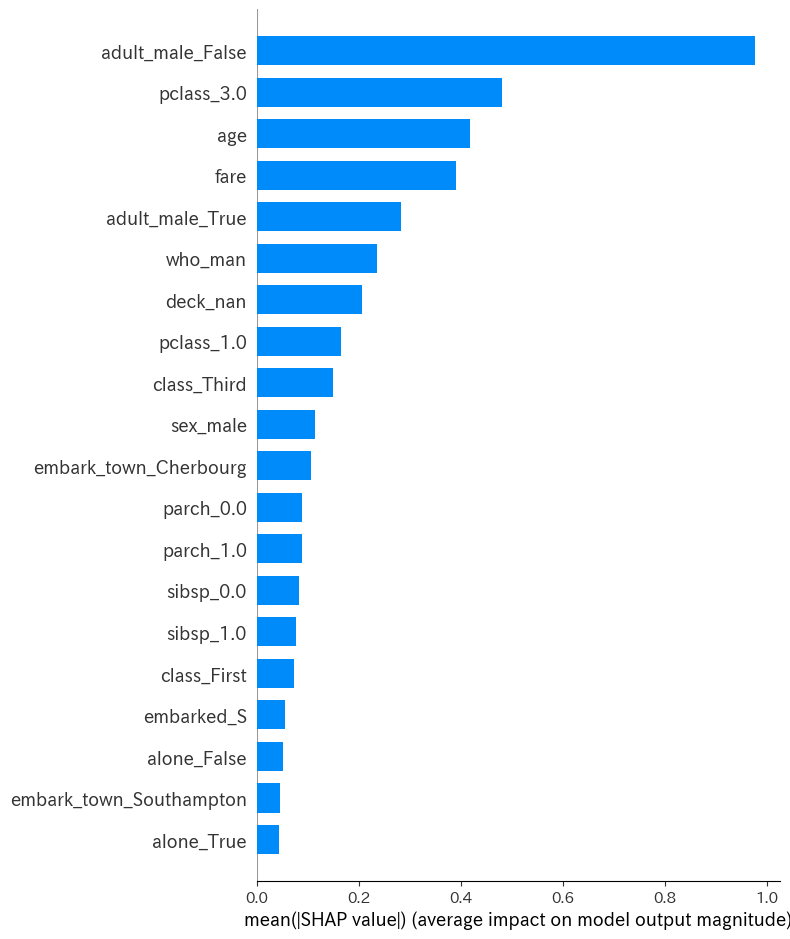

In [40]:
# summary plot(bar)
shap.summary_plot(
    shap_values,
    train_x,
    plot_type='bar'
)

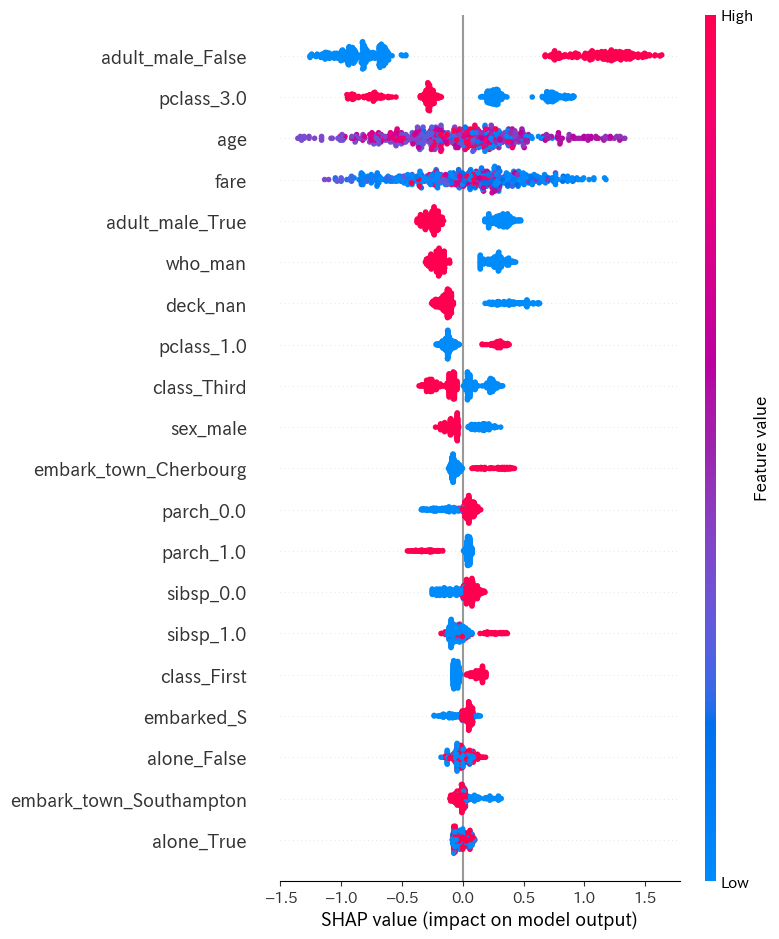

In [41]:
# summary plot
shap.summary_plot(
    shap_values,
    train_x
)

## dependence_plot

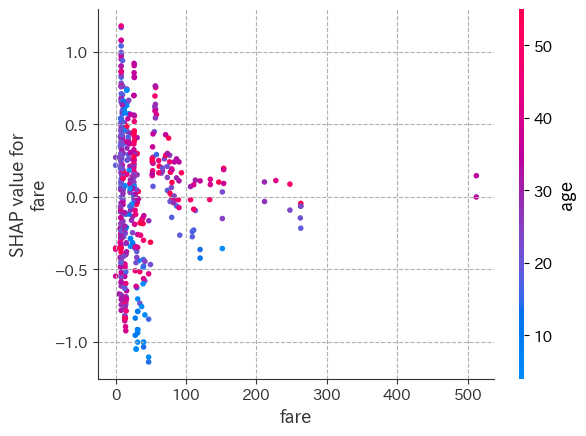

In [42]:
fig, ax = plt.subplots(dpi=100)
ax.grid(ls='--')

# dependence
shap.dependence_plot(
    ind='fare',
    shap_values=shap_values,
    features=train_x,
    feature_names=features,
    ax=ax
)

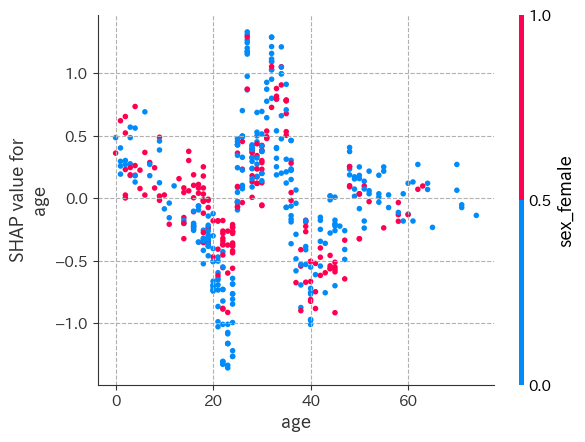

In [43]:
fig, ax = plt.subplots(dpi=100)
ax.grid(ls='--')

# dependence
shap.dependence_plot(
    ind='age',
    shap_values=shap_values,
    features=train_x,
    feature_names=features,
    ax=ax
)

## force_plot

### idx:1

In [44]:
target_row_index = 1
display(pd.DataFrame(train_x.iloc[target_row_index]).T)
print('survived:', train_y.iloc[target_row_index])

,age,fare,adult_male_False,adult_male_True,adult_male_nan,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,embark_town_nan,who_child,who_man,who_woman,who_nan,pclass_1.0,pclass_2.0,pclass_3.0,pclass_nan,class_First,class_Second,class_Third,class_nan,sex_female,sex_male,sex_nan,parch_0.0,parch_1.0,parch_2.0,parch_3.0,parch_4.0,parch_5.0,parch_6.0,parch_nan,alone_False,alone_True,alone_nan,sibsp_0.0,sibsp_1.0,sibsp_2.0,sibsp_3.0,sibsp_4.0,sibsp_5.0,sibsp_nan,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_nan,embarked_C,embarked_Q,embarked_S,embarked_nan
827,1.0,37.0042,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


survived: 1


In [45]:
# force plot
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values[target_row_index,:],
    features=train_x.iloc[target_row_index,:],
    feature_names=features
)

## waterfall

In [46]:
# waterfall用のexplainer
explainer_waterfall = shap.TreeExplainer(model=lgbc)

# .shap_values不使用
shap_values_waterfall = explainer_waterfall(
    train_x,
    check_additivity=False
)

In [47]:
pd.concat([train_y, train_x], axis=1).reset_index(drop=True).head(10)

,survived,age,fare,adult_male_False,adult_male_True,adult_male_nan,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,embark_town_nan,who_child,who_man,who_woman,who_nan,pclass_1.0,pclass_2.0,pclass_3.0,pclass_nan,class_First,class_Second,class_Third,class_nan,sex_female,sex_male,sex_nan,parch_0.0,parch_1.0,parch_2.0,parch_3.0,parch_4.0,parch_5.0,parch_6.0,parch_nan,alone_False,alone_True,alone_nan,sibsp_0.0,sibsp_1.0,sibsp_2.0,sibsp_3.0,sibsp_4.0,sibsp_5.0,sibsp_nan,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_nan,embarked_C,embarked_Q,embarked_S,embarked_nan
0,0,27,211.5000,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
1,1,1,37.0042,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
2,0,24,8.0500,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
3,0,19,0.0000,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,1,50,10.5000,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
5,0,39,7.9250,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
6,0,25,26.0000,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
7,0,18,18.0000,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
8,0,18,7.7750,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
9,0,20,7.0500,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [48]:
pd.concat([train_y, train_x], axis=1).reset_index(drop=True).tail(10)

,survived,age,fare,adult_male_False,adult_male_True,adult_male_nan,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,embark_town_nan,who_child,who_man,who_woman,who_nan,pclass_1.0,pclass_2.0,pclass_3.0,pclass_nan,class_First,class_Second,class_Third,class_nan,sex_female,sex_male,sex_nan,parch_0.0,parch_1.0,parch_2.0,parch_3.0,parch_4.0,parch_5.0,parch_6.0,parch_nan,alone_False,alone_True,alone_nan,sibsp_0.0,sibsp_1.0,sibsp_2.0,sibsp_3.0,sibsp_4.0,sibsp_5.0,sibsp_nan,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_nan,embarked_C,embarked_Q,embarked_S,embarked_nan
489,1,34,13.0000,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
490,1,2,26.0000,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
491,0,41,39.6875,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
492,0,65,61.9792,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
493,1,47,52.5542,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
494,0,54,77.2875,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
495,0,39,13.0000,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
496,0,21,77.2875,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
497,1,29,7.7500,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
498,0,54,51.8625,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


### idx:1

In [49]:
target_row_index = 1
display(pd.DataFrame(train_x.iloc[target_row_index]).T)
print('survived:', train_y.iloc[target_row_index])

,age,fare,adult_male_False,adult_male_True,adult_male_nan,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,embark_town_nan,who_child,who_man,who_woman,who_nan,pclass_1.0,pclass_2.0,pclass_3.0,pclass_nan,class_First,class_Second,class_Third,class_nan,sex_female,sex_male,sex_nan,parch_0.0,parch_1.0,parch_2.0,parch_3.0,parch_4.0,parch_5.0,parch_6.0,parch_nan,alone_False,alone_True,alone_nan,sibsp_0.0,sibsp_1.0,sibsp_2.0,sibsp_3.0,sibsp_4.0,sibsp_5.0,sibsp_nan,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_nan,embarked_C,embarked_Q,embarked_S,embarked_nan
827,1.0,37.0042,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


survived: 1


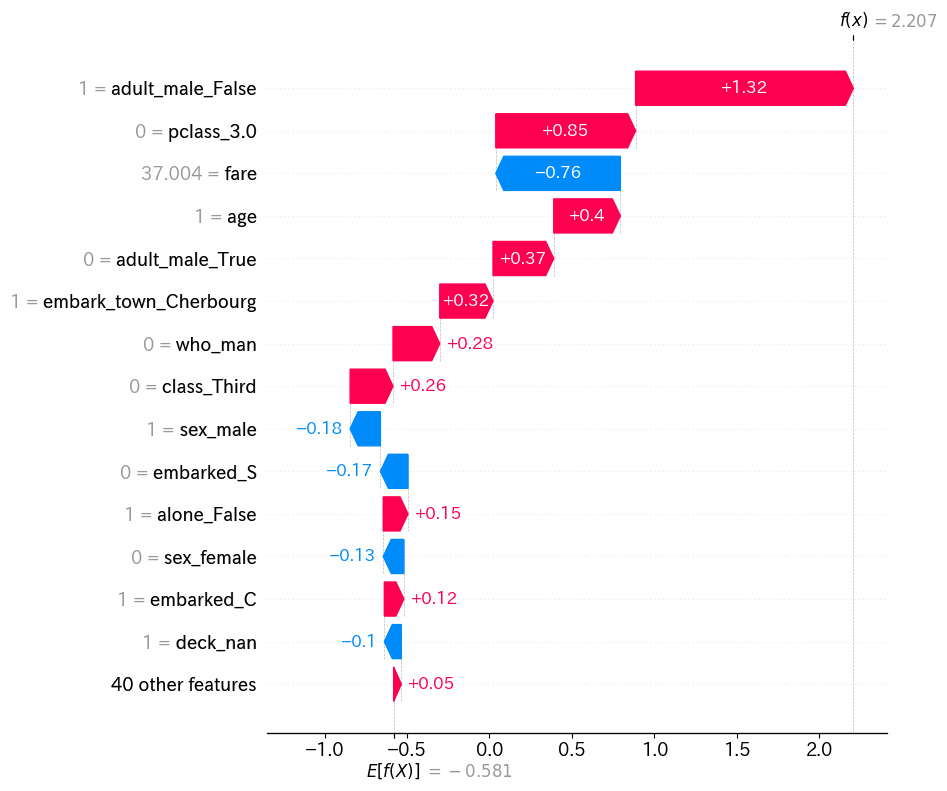

In [50]:
# 変数表示数
max_display_num = 15

# waterfall
shap.waterfall_plot(
    shap_values=shap_values_waterfall[target_row_index,:],
    max_display=max_display_num,
    show=True
)

In [51]:
temp_shap_values = shap_values_waterfall[target_row_index,:]
temp_shap_values

.values =
array([ 0.40404533, -0.75541806,  1.32053934,  0.36812461,  0.        ,
        0.32291537,  0.        ,  0.06311793,  0.        , -0.01359975,
        0.28346807,  0.00424063,  0.        , -0.05585547, -0.02657807,
        0.84795952,  0.        , -0.06255402, -0.00414152,  0.26004431,
        0.        , -0.12503614, -0.1834857 ,  0.        , -0.05642514,
        0.0428915 ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.15010125,  0.06026078,  0.        ,
        0.09987514, -0.01349201,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.00863352,
        0.        ,  0.        ,  0.        ,  0.        , -0.10313573,
        0.11852636,  0.        , -0.1674021 ,  0.        ])

.base_values =
-0.5805311415844109

.data =
array([ 1.    , 37.0042,  1.    ,  0.    ,  0.    ,  1.    ,  0.    ,
        0.    ,  0.    ,  1.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        1.    ,  0.    , 

In [52]:
temp_shap_values.values.sum() + temp_shap_values.base_values

2.207088801462585

### idx:495

In [53]:
target_row_index = 495
display(pd.DataFrame(train_x.iloc[target_row_index]).T)
print('survived:', train_y.iloc[target_row_index])

,age,fare,adult_male_False,adult_male_True,adult_male_nan,embark_town_Cherbourg,embark_town_Queenstown,embark_town_Southampton,embark_town_nan,who_child,who_man,who_woman,who_nan,pclass_1.0,pclass_2.0,pclass_3.0,pclass_nan,class_First,class_Second,class_Third,class_nan,sex_female,sex_male,sex_nan,parch_0.0,parch_1.0,parch_2.0,parch_3.0,parch_4.0,parch_5.0,parch_6.0,parch_nan,alone_False,alone_True,alone_nan,sibsp_0.0,sibsp_1.0,sibsp_2.0,sibsp_3.0,sibsp_4.0,sibsp_5.0,sibsp_nan,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_nan,embarked_C,embarked_Q,embarked_S,embarked_nan
795,39.0,13.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


survived: 0


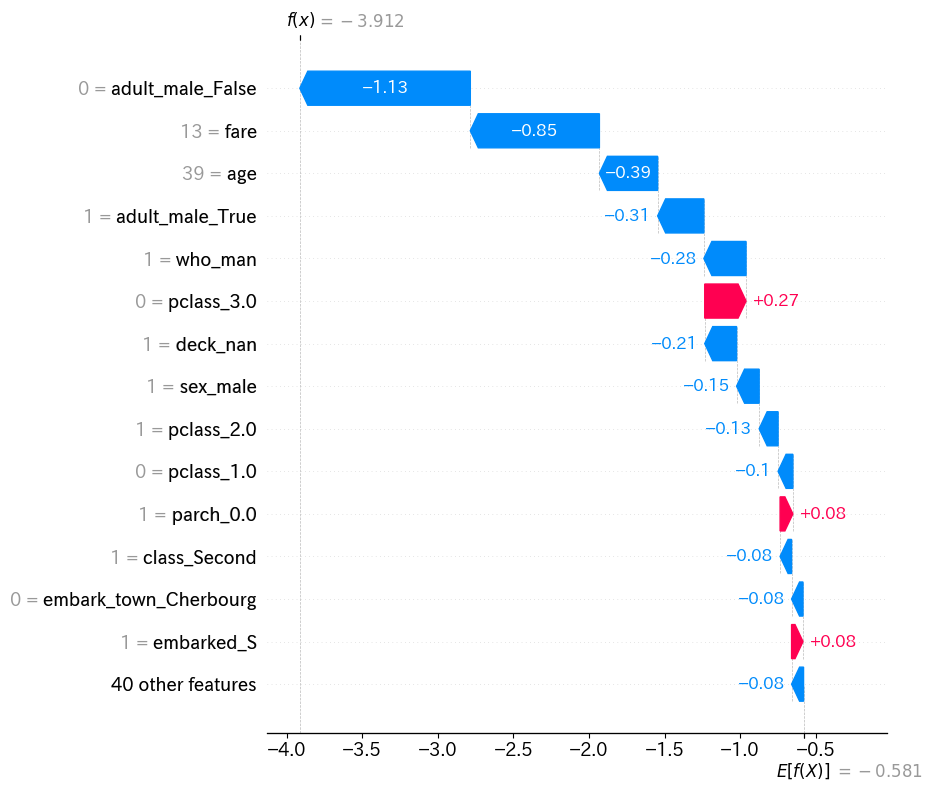

In [54]:
# 変数表示数
max_display_num = 15

# waterfall
shap.waterfall_plot(
    shap_values=shap_values_waterfall[target_row_index,:],
    max_display=max_display_num,
    show=True
)

In [55]:
temp_shap_values = shap_values_waterfall[target_row_index,:]
temp_shap_values

.values =
array([-3.85183890e-01, -8.53667683e-01, -1.12763384e+00, -3.05853080e-01,
        0.00000000e+00, -7.56405641e-02,  0.00000000e+00,  3.24108286e-03,
        0.00000000e+00,  1.99198726e-04, -2.78948368e-01, -2.94900410e-02,
        0.00000000e+00, -9.78396507e-02, -1.25127408e-01,  2.73385529e-01,
        0.00000000e+00, -7.26324925e-02, -7.58948645e-02,  4.09404537e-02,
        0.00000000e+00, -1.53159860e-02, -1.49356692e-01,  0.00000000e+00,
        8.45609516e-02,  3.03455410e-02,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.78434726e-02,  4.66624345e-02,  0.00000000e+00,  1.38369315e-02,
       -5.70036786e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        8.36408840e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -2.10705654e-01, -3.04063474e-02,  0.00000000e+00,
        7.54864

In [56]:
temp_shap_values.values.sum() + temp_shap_values.base_values

-3.9120522301793677

In [57]:
train_y.mean(), logit(train_y.mean())

(0.39879759519038077, -0.4104776499317085)

In [58]:
lgbc_prob_train_y.mean(), logit(lgbc_prob_train_y.mean())

(0.3867375869415046, -0.4610465312484594)

# notebookをhtml化

In [59]:
!jupyter nbconvert --to html ./src/20240831_LightGBMとSHAPの使用_colab.ipynb

[NbConvertApp] Converting notebook ./src/20240831_LightGBMとSHAPの使用_colab.ipynb to html
[NbConvertApp] Writing 685979 bytes to src/20240831_LightGBMとSHAPの使用_colab.html
